In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import os
import pathlib
import datetime

In [ ]:
# access Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

%cd gdrive/MyDrive/'Colab Notebooks'/

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks


In [ ]:
# Load image files
file_path = r"concrete_crack"
data_dir = pathlib.Path(file_path)

# Split into train-validation set
SEED = 12345
IMG_SIZE = (160,160)
BATCH_SIZE = 16
train_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            validation_split = 0.3,
                                                            subset = 'training',
                                                            seed = SEED,
                                                            shuffle = True,
                                                            image_size = IMG_SIZE,
                                                            batch_size = BATCH_SIZE)
val_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                          validation_split = 0.3,
                                                          subset = 'validation',
                                                          seed = SEED,
                                                          shuffle = True,
                                                          image_size = IMG_SIZE,
                                                          batch_size = BATCH_SIZE)

Found 1000 files belonging to 2 classes.
Using 700 files for training.
Found 1000 files belonging to 2 classes.
Using 300 files for validation.


In [ ]:
# Split into validation-test set
val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches//5)
validation_dataset = val_dataset.skip(val_batches//5)

In [ ]:
# Create prefetch dataset
AUTOTUNE = tf.data.AUTOTUNE

train_dataset_pf = train_dataset.prefetch(buffer_size = AUTOTUNE)
validation_dataset_pf = validation_dataset.prefetch(buffer_size = AUTOTUNE)
test_dataset_pf = test_dataset.prefetch(buffer_size = AUTOTUNE)

# Data preparation completed here

In [ ]:
# Create model by applying transfer learning using MobileNetV2
# Define a layer that preprocess inputs for the transfer learning model

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


In [ ]:
# Create base model with MobileNetV2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                               include_top = False,
                                               weights = 'imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# Freeze the base model and view the model structure
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
# Create classification layers with global average pooling and dense layer
class_names = train_dataset.class_names
global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()
output_dense = tf.keras.layers.Dense(len(class_names),activation='softmax')

In [ ]:
# Use functional API to build the entire model
inputs = tf.keras.Input(shape = IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x)
x = global_avg_pool(x)
outputs = output_dense(x)

model = tf.keras.Model(inputs,outputs)

#Print out the model structure
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [ ]:
# Compile model
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer=adam,loss=loss,metrics=['accuracy'])

In [ ]:
# Perform training
EPOCHS = 10
base_log_path = r"log_concrete_crack"
log_path = os.path.join(base_log_path, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=2)
history = model.fit(train_dataset_pf,validation_data=validation_dataset_pf,epochs=EPOCHS,callbacks=[tb_callback,es_callback])

Epoch 1/10
44/44 [==============================] - 220s 4s/step - loss: 0.2676 - accuracy: 0.9371 - val_loss: 0.1520 - val_accuracy: 0.9643
Epoch 2/10
44/44 [==============================] - 16s 361ms/step - loss: 0.1173 - accuracy: 0.9857 - val_loss: 0.0972 - val_accuracy: 0.9802
Epoch 3/10
44/44 [==============================] - 16s 364ms/step - loss: 0.0718 - accuracy: 0.9914 - val_loss: 0.0558 - val_accuracy: 0.9960
Epoch 4/10
44/44 [==============================] - 16s 371ms/step - loss: 0.0514 - accuracy: 0.9929 - val_loss: 0.0429 - val_accuracy: 1.0000
Epoch 5/10
44/44 [==============================] - 16s 356ms/step - loss: 0.0398 - accuracy: 0.9957 - val_loss: 0.0416 - val_accuracy: 0.9921
Epoch 6/10
44/44 [==============================] - 15s 344ms/step - loss: 0.0323 - accuracy: 0.9971 - val_loss: 0.0284 - val_accuracy: 0.9960
Epoch 7/10
44/44 [==============================] - 14s 310ms/step - loss: 0.0271 - accuracy: 0.9971 - val_loss: 0.0262 - val_accuracy: 0.9960
E

In [ ]:
# Evaluate with test dataset
test_loss,test_accuracy = model.evaluate(test_dataset_pf)

print('----------Test Result----------')
print(f'Loss = {test_loss}')
print(f'Accuracy = {test_accuracy}')

3/3 [==============================] - 1s 213ms/step - loss: 0.0439 - accuracy: 0.9792
----------Test Result----------
Loss = 0.04391506314277649
Accuracy = 0.9791666865348816


In [ ]:
# Deploy model to make prediction
image_batch, label_batch = test_dataset_pf.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
class_predictions = np.argmax(predictions,axis=1)

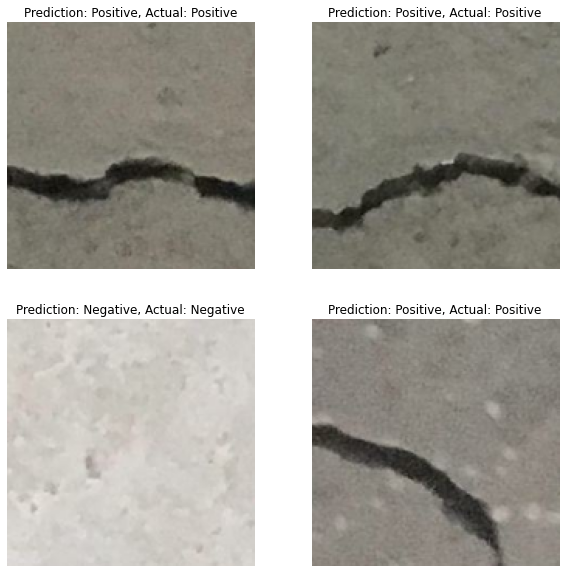

In [ ]:
# Show some prediction results
plt.figure(figsize=(10,10))

for i in range(4):
    axs = plt.subplot(2,2,i+1)
    plt.imshow(image_batch[i].astype('uint8'))
    current_prediction = class_names[class_predictions[i]]
    current_label = class_names[label_batch[i]]
    plt.title(f"Prediction: {current_prediction}, Actual: {current_label}")
    plt.axis('off')
    
plt.show()